# Import Library

In [1]:
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

# Define Global Variables

In [2]:
NUM_WORDS = 30000
EMBEDDING_DIM = 16
MAXLEN = 100
PADDING = 'post'
OOV_TOKEN = "<OOV>"
TRAIN_FILE = "./dataset/processed_train.csv"
TEST_FILE = "./dataset/processed_test.csv"
STOPWORDS_FILE = "./dataset/stopwordbahasa.csv"
STOPWORDS = []

# Define Remove Stopwords

In [3]:
def load_stopwords(stopwords_file=STOPWORDS_FILE):
    """
    Loads the stopwords from the stopwords file
    
    Args:
        stopwords_file (string): path to the stopwords file
    Returns:
        stopwords (list): list of stopwords
    """
    with open(stopwords_file, 'r') as f:
        stopwords = []
        reader = csv.reader(f)
        for row in reader:
            stopwords.append(row[0])
        
        return stopwords

STOPWORDS = load_stopwords(STOPWORDS_FILE)

In [4]:
STOPWORDS[:5]

['ada', 'adalah', 'adanya', 'adapun', 'agak']

In [5]:
def remove_stopwords(sentence, stopwords=STOPWORDS):
    """
    Removes a list of stopwords
    
    Args:
        sentence (string): sentence to remove the stopwords from
        stopwords (list): list of stopwords to remove from the sentence
        
    Returns:
        sentence (string): lowercase sentence without the stopwords
    """
    sentence = sentence.lower()

    words = sentence.split()
    no_words = [w for w in words if w not in stopwords]
    sentence = " ".join(no_words)

    return sentence

# Load Train and Test Data

In [6]:
def parse_data_from_file(filename):
    """
    Extracts sentences and labels from a CSV file
    
    Args:
        filename (string): path to the CSV file
    
    Returns:
        sentences, labels (list of string, list of string): tuple containing lists of sentences and labels
    """
    sentences = []
    labels = []
    with open(filename, 'r', encoding="utf8") as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        for row in reader:
            toxicity = int(row[2]) + int(row[3]) + int(row[4]) + int(row[5])
            if toxicity > 0:
                labels.append(1)
            else:
                labels.append(0)
            sentence = row[6]
            sentence = remove_stopwords(sentence)
            sentences.append(sentence)

    return sentences, np.array(labels)

In [7]:
train_sentences, train_labels = parse_data_from_file(TRAIN_FILE)
test_sentences, test_labels = parse_data_from_file(TEST_FILE)

In [8]:
print(train_sentences[0])
print(train_labels[0])

print(test_sentences[0])
print(test_labels[0])

# number of sentences in the training set
print(f"No. of sentences in the training set: {len(train_sentences)}")

# number of sentences in the test set
print(f"No. of sentences in the test set: {len(test_sentences)}")

# shape of the labels in the training set
print(f"Shape of the labels in the training set: {train_labels.shape}")

# shape of the labels in the test set
print(f"Shape of the labels in the test set: {test_labels.shape}")


jabar provinsi barokah nwoi anjing bodoh npropinsi ngerusak ngebakar gereja jatim provinsi lumbung nasbung jatim npropinsi penghasil gembong teroris jateng lumbung nasbung jateng ngarang stereotip piliah pilih nbangsat pecun
1
spanduk prof video orasi buku lainlain sngat heran rkyat tolol jls niat hizbut tahrir tegakan khilafah ganti negara kesatuan republik indonesia berkilah tegakan khilafah munafik apanya khilafah
1
No. of sentences in the training set: 6995
No. of sentences in the test set: 778
Shape of the labels in the training set: (6995,)
Shape of the labels in the test set: (778,)


# Tokenization - Sequences and Padding

In [9]:
def fit_tokenizer(train_sentences, num_words, oov_token):
    """
    Instantiates the Tokenizer class on the training sentences
    
    Args:
        train_sentences (list of string): lower-cased sentences without stopwords to be used for training
        num_words (int) - number of words to keep when tokenizing
        oov_token (string) - symbol for the out-of-vocabulary token
    
    Returns:
        tokenizer (object): an instance of the Tokenizer class containing the word-index dictionary
    """
    
    ### START CODE HERE
    
    # Instantiate the Tokenizer class, passing in the correct values for num_words and oov_token
    tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
    
    # Fit the tokenizer to the training sentences
    tokenizer.fit_on_texts(train_sentences)
    
    ### END CODE HERE
    
    return tokenizer

In [10]:
# Test function
tokenizer = fit_tokenizer(train_sentences, NUM_WORDS, OOV_TOKEN)
word_index = tokenizer.word_index

print(f"Vocabulary contains {len(word_index)} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")

Vocabulary contains 28899 words

<OOV> token included in vocabulary


In [11]:
def seq_and_pad(sentences, tokenizer, padding, maxlen):
    """
    Generates an array of token sequences and pads them to the same length
    
    Args:
        sentences (list of string): list of sentences to tokenize and pad
        tokenizer (object): Tokenizer instance containing the word-index dictionary
        padding (string): type of padding to use
        maxlen (int): maximum length of the token sequence
    
    Returns:
        padded_sequences (array of int): tokenized sentences padded to the same length
    """ 
    
    ### START CODE HERE
       
    # Convert sentences to sequences
    sequences = tokenizer.texts_to_sequences(sentences)
    
    # Pad the sequences using the correct padding and maxlen
    padded_sequences = pad_sequences(sequences, padding=padding, maxlen=maxlen)
    
    ### END CODE HERE
    
    return padded_sequences

In [12]:
# Test your function
train_padded_seq = seq_and_pad(train_sentences, tokenizer, PADDING, MAXLEN)
test_padded_seq = seq_and_pad(test_sentences, tokenizer, PADDING, MAXLEN)

print(f"Padded training sequences have shape: {train_padded_seq.shape}\n")
print(f"Padded validation sequences have shape: {test_padded_seq.shape}")

Padded training sequences have shape: (6995, 100)

Padded validation sequences have shape: (778, 100)


# Create Model

In [13]:
# model
def create_model(num_words, embedding_dim, maxlen):
    """
    Creates a text classifier model
    
    Args:
        num_words (int): size of the vocabulary for the Embedding layer input
        embedding_dim (int): dimensionality of the Embedding layer output
        maxlen (int): length of the input sequences
    
    Returns:
        model (tf.keras Model): the text classifier model
    """
    
    tf.random.set_seed(123)
    
    ### START CODE HERE
    
    model = tf.keras.Sequential([ 
        tf.keras.layers.Embedding(num_words, embedding_dim, input_length=maxlen),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(20, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])
    
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]) 

    ### END CODE HERE

    return model

In [14]:
model = create_model(NUM_WORDS, EMBEDDING_DIM, MAXLEN)

history = model.fit(train_padded_seq, train_labels, epochs=100, validation_data=(test_padded_seq, test_labels))

Epoch 1/100
219/219 [==============================] - 3s 10ms/step - loss: 0.6800 - accuracy: 0.5683 - precision: 0.5661 - recall: 0.9911 - val_loss: 0.6710 - val_accuracy: 0.6414 - val_precision: 0.6130 - val_recall: 0.9606
Epoch 2/100
219/219 [==============================] - 2s 7ms/step - loss: 0.6030 - accuracy: 0.6968 - precision: 0.6562 - recall: 0.9664 - val_loss: 0.5349 - val_accuracy: 0.8021 - val_precision: 0.8022 - val_recall: 0.8542
Epoch 3/100
219/219 [==============================] - 2s 8ms/step - loss: 0.4215 - accuracy: 0.8639 - precision: 0.8557 - recall: 0.9114 - val_loss: 0.4338 - val_accuracy: 0.8123 - val_precision: 0.8341 - val_recall: 0.8264
Epoch 4/100
219/219 [==============================] - 2s 7ms/step - loss: 0.3061 - accuracy: 0.8969 - precision: 0.9004 - recall: 0.9180 - val_loss: 0.4063 - val_accuracy: 0.8046 - val_precision: 0.8398 - val_recall: 0.8009
Epoch 5/100
219/219 [==============================] - 2s 8ms/step - loss: 0.2369 - accuracy: 0.920

In [15]:
# model_2
def create_model(num_words, embedding_dim, maxlen):
    """
    Creates a text classifier model
    
    Args:
        num_words (int): size of the vocabulary for the Embedding layer input
        embedding_dim (int): dimensionality of the Embedding layer output
        maxlen (int): length of the input sequences
    
    Returns:
        model (tf.keras Model): the text classifier model
    """
    
    tf.random.set_seed(123)
    
    ### START CODE HERE
    
    model = tf.keras.Sequential([ 
        tf.keras.layers.Embedding(num_words, embedding_dim, input_length=maxlen),
        tf.keras.layers.Conv1D(filters=128, kernel_size=7, activation="relu"),
        tf.keras.layers.GlobalMaxPooling1D(),
        tf.keras.layers.Dense(20, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])
    
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=['accuracy']) 

    ### END CODE HERE

    return model

In [ ]:
model_2 = create_model(NUM_WORDS, EMBEDDING_DIM, MAXLEN)

history_2 = model_2.fit(train_padded_seq, train_labels, epochs=100, validation_data=(test_padded_seq, test_labels))

In [17]:
# model_3
def create_model(num_words, embedding_dim, maxlen):
    """
    Creates a text classifier model
    
    Args:
        num_words (int): size of the vocabulary for the Embedding layer input
        embedding_dim (int): dimensionality of the Embedding layer output
        maxlen (int): length of the input sequences
    
    Returns:
        model (tf.keras Model): the text classifier model
    """
    
    tf.random.set_seed(123)
    
    ### START CODE HERE
    
    model = tf.keras.Sequential([ 
        tf.keras.layers.Embedding(num_words, embedding_dim, input_length=maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
        tf.keras.layers.Dense(20, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])
    
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=['accuracy']) 

    ### END CODE HERE

    return model

In [ ]:
model_3 = create_model(NUM_WORDS, EMBEDDING_DIM, MAXLEN)

history_3 = model_3.fit(train_padded_seq, train_labels, epochs=100, validation_data=(test_padded_seq, test_labels))

In [1]:
# model_4
def create_model(num_words, embedding_dim, maxlen):
    """
    Creates a text classifier model
    
    Args:
        num_words (int): size of the vocabulary for the Embedding layer input
        embedding_dim (int): dimensionality of the Embedding layer output
        maxlen (int): length of the input sequences
    
    Returns:
        model (tf.keras Model): the text classifier model
    """
    
    tf.random.set_seed(123)
    
    ### START CODE HERE
    
    model = tf.keras.Sequential([ 
        tf.keras.layers.Embedding(num_words, embedding_dim, input_length=maxlen),
        tf.keras.layers.Conv1D(filters=128, kernel_size=7, activation="relu"),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50)),
        tf.keras.layers.Dense(100, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])
    
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=['accuracy']) 

    ### END CODE HERE

    return model

In [15]:
model_4 = create_model(NUM_WORDS, EMBEDDING_DIM, MAXLEN)

model_4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          3000000   
                                                                 
 conv1d (Conv1D)             (None, 94, 128)           89728     
                                                                 
 bidirectional (Bidirectiona  (None, 100)              71600     
 l)                                                              
                                                                 
 dense (Dense)               (None, 100)               10100     
                                                                 
 dense_1 (Dense)             (None, 4)                 404       
                                                                 
Total params: 3,171,832
Trainable params: 3,171,832
Non-trainable params: 0
______________________________________________

In [17]:
history_4 = model_4.fit(train_padded_seq, train_labels, epochs=100, validation_data=(test_padded_seq, test_labels))

Epoch 1/100
219/219 [==============================] - 16s 73ms/step - loss: 0.0266 - accuracy: 0.6325 - val_loss: 0.5303 - val_accuracy: 0.4910
Epoch 2/100
219/219 [==============================] - 16s 73ms/step - loss: 0.0174 - accuracy: 0.6009 - val_loss: 0.5870 - val_accuracy: 0.4704
Epoch 3/100
219/219 [==============================] - 18s 84ms/step - loss: 0.0126 - accuracy: 0.5657 - val_loss: 0.6244 - val_accuracy: 0.5771
Epoch 4/100
219/219 [==============================] - 15s 70ms/step - loss: 0.0101 - accuracy: 0.7165 - val_loss: 0.6517 - val_accuracy: 0.5591
Epoch 5/100
219/219 [==============================] - 18s 81ms/step - loss: 0.0086 - accuracy: 0.6436 - val_loss: 0.6311 - val_accuracy: 0.5141
Epoch 6/100
219/219 [==============================] - 16s 75ms/step - loss: 0.0085 - accuracy: 0.7525 - val_loss: 0.6432 - val_accuracy: 0.5643
Epoch 7/100
219/219 [==============================] - 16s 73ms/step - loss: 0.0083 - accuracy: 0.7122 - val_loss: 0.7092 - val_ac

KeyboardInterrupt: 

# Evaluate The Model

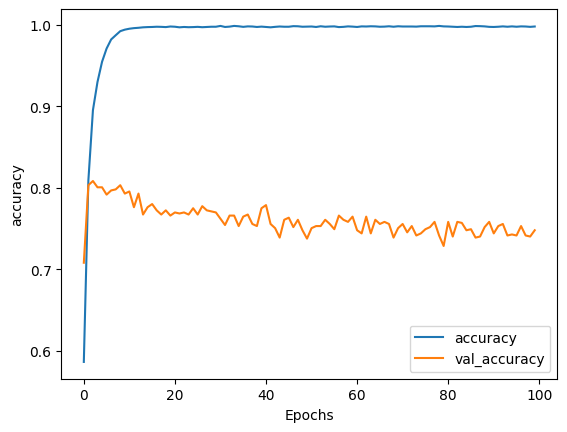

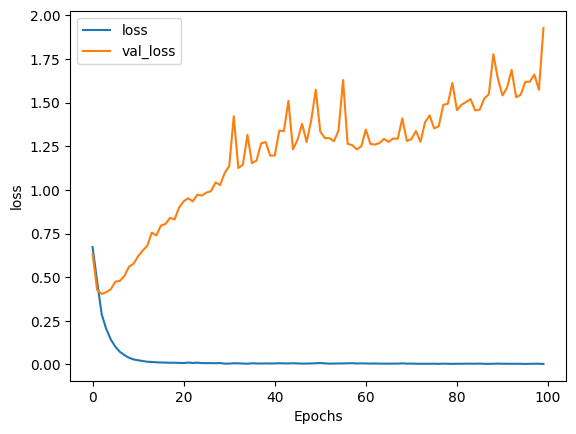

In [19]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

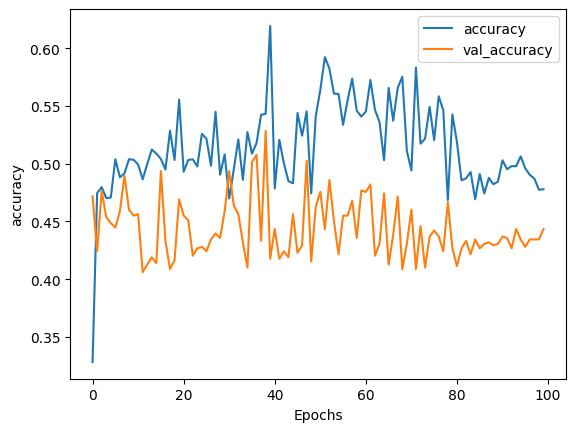

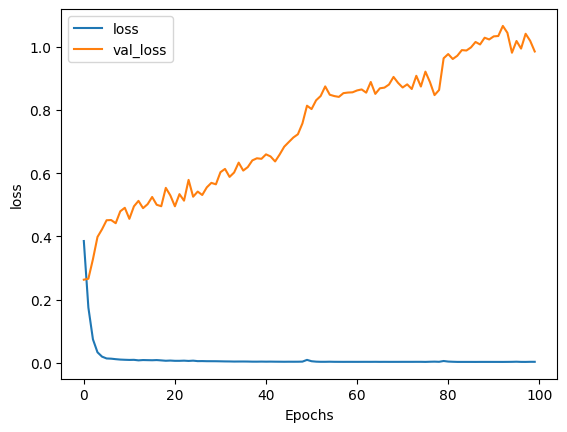

In [45]:
def plot_graphs(history_2, metric):
    plt.plot(history_2.history[metric])
    plt.plot(history_2.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_graphs(history_2, "accuracy")
plot_graphs(history_2, "loss")

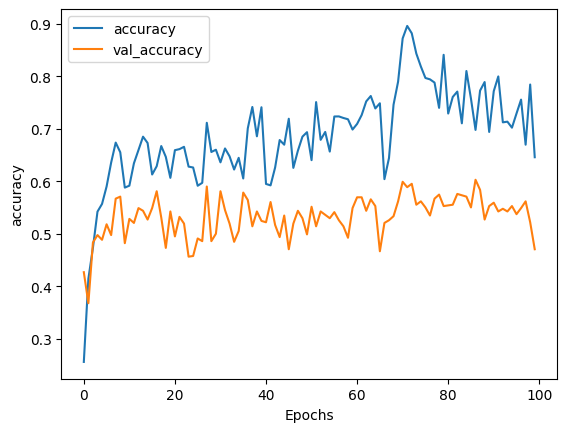

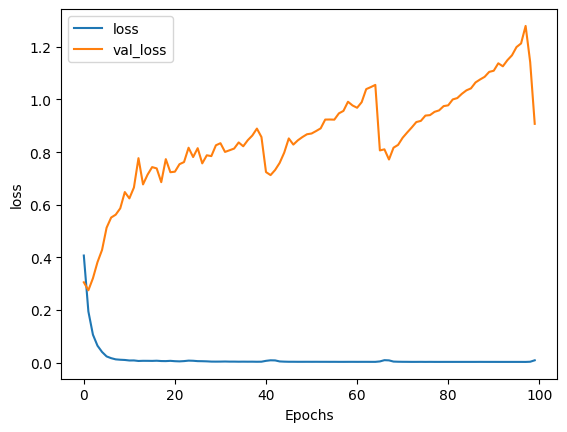

In [46]:
def plot_graphs(history_3, metric):
    plt.plot(history_3.history[metric])
    plt.plot(history_3.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_graphs(history_3, "accuracy")
plot_graphs(history_3, "loss")

In [18]:
def plot_graphs(history_4, metric):
    plt.plot(history_4.history[metric])
    plt.plot(history_4.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_graphs(history_4, "accuracy")
plot_graphs(history_4, "loss")

NameError: name 'history_4' is not defined

# Save The Model

In [20]:
model.save('toxic_comment_model_var_1.h5')

# Make Prediction

In [48]:
model.predict(test_padded_seq) > 0.5 # 0.5 is the threshold

25/25 [==============================] - 0s 2ms/step


array([[False, False,  True, False],
       [ True, False, False, False],
       [False, False, False, False],
       ...,
       [ True, False, False,  True],
       [False, False, False, False],
       [False,  True, False,  True]])

# Load Model

In [ ]:
model = tf.keras.models.load_model('toxic_comment_model_var_1.h5')